# in this phyloseq I am using the cutadapt product where:
- primers were not anchored, and discard_untrimmed was used

## this led to higher numbers of reads in dada2

In [3]:
require(data.table)
require(tidyverse)
require(dada2)
require(phyloseq)
require(genefilter)
require(ggplot2)
require(RColorBrewer)
require(metacoder)
require(vegan)
require(DESeq2)
options(repr.plot.width=20, repr.plot.height=15)

Loading required package: dada2

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘dada2’”


In [13]:
#load sample metadata skipping first row
#load tracker for reads
track=fread("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/ASVs/Seqnums_16S.csv")
#load sample metadata
samdt=fread("/home/caroline_desouza_uml_edu/2_randomized_immune_metagenomics_PCR.csv", header=TRUE)
conditions=read.csv(file="/home/caroline_desouza_uml_edu/pcr_meta.csv", header=TRUE, row.names=1)
#load csv files after removing chimeras
asv_all=fread("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/ASVs/16S_ASV_nochim.csv")
taxa=read.csv(file="/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/ASVs/16S_taxa.csv", header=TRUE, row.names=1)

### organize sample data

In [14]:
#cleaning samdt 
samdt <- samdt[samdt$Date_16S != 'NA', ]
# Create a new data frame with the species, date, and transect columns
# Example samdt (make sure your data is a data.table)
setDT(samdt)
# Split Tubelabel_species by "_" and assign new columns
samdt[, c("date", "transect", "species") := {
  parts <- strsplit(Tubelabel_species, "_")
  list(
    sapply(parts, `[`, 1),  # date is first element
    sapply(parts, `[`, 4),  # transect is 4th element
    sapply(parts, `[`, 6)   # species is 6th element
  )
}]
samdt <- samdt[, c("V1", "Date_Extracted", "Raw_ng_ul", "Extraction_physical_location", "Date_Enriched", "Date_ITS2", "Microbe_Location") := NULL]

#add conditions from pcr=read.csv(file="/home/caroline_desouza_uml_edu/pcr_meta.csv", header=TRUE, row.names=1)
samdt <- 

In [15]:
head(samdt)
class(asv_all)

Tubelabel_species,Health_Status,colony,Date_16S,16S double band,date,transect,species
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
052022_BEL_CBC_T1_2_SSID,Healthy,1_3,1_22_2025,,052022,T1,SSID
092023_BEL_CBC_T1_175_PAST,Healthy,1_13,1_22_2025,y,092023,T1,PAST
022024_BEL_CBC_T3_851_PSTR,Healthy,3_70,1_23_2025,,022024,T3,PSTR
082024_BEL_CBC_T4_1609_OFAV,Healthy,4_78,1_23_2025,y,082024,T4,OFAV
122023_BEL_CBC_T3_526_SSID,Healthy,3_5,1_23_2025,,122023,T3,SSID
112023_BEL_CBC_T4_399_MCAV,Healthy,4_76,1_23_2025,,112023,T4,MCAV


[1] "data.table" "data.frame"

In [16]:
# Rename double band
sample_16Sdoubl <- setnames(samdt, "16S double band", "double_band", skip_absent=TRUE)
# Rename a date to date sampled
sample_date <- setnames(sample_16Sdoubl, "date", "date_sampled", skip_absent=TRUE)
#changing format of date_sampled to be Jan 2024
sample_date$date_sampled <- as.factor(sample_date$date_sampled)
# Convert to Date format 
sample_date$DateFormatted <- as.Date(paste0(sample_date$date_sampled, "01"), format = "%m%Y%d")
# now will have a new column that has Month Year instead of date_sampled
sample_date$MonthYear <- format(sample_date$DateFormatted, "%b %Y")
sample_date$MonthYear <- factor(sample_date$MonthYear, levels = unique(sample_date$MonthYear))

In [17]:
 #cleaning up sample_norm to only be metadata
samdt<- sample_date[, c("Tubelabel_species", "Health_Status", "colony", "Date_16S", "double_band", "date_sampled", "transect", "species", "MonthYear")]
head(samdt)

Tubelabel_species,Health_Status,colony,Date_16S,double_band,date_sampled,transect,species,MonthYear
<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>
052022_BEL_CBC_T1_2_SSID,Healthy,1_3,1_22_2025,,052022,T1,SSID,May 2022
092023_BEL_CBC_T1_175_PAST,Healthy,1_13,1_22_2025,y,092023,T1,PAST,Sep 2023
022024_BEL_CBC_T3_851_PSTR,Healthy,3_70,1_23_2025,,022024,T3,PSTR,Feb 2024
082024_BEL_CBC_T4_1609_OFAV,Healthy,4_78,1_23_2025,y,082024,T4,OFAV,Aug 2024
122023_BEL_CBC_T3_526_SSID,Healthy,3_5,1_23_2025,,122023,T3,SSID,Dec 2023
112023_BEL_CBC_T4_399_MCAV,Healthy,4_76,1_23_2025,,112023,T4,MCAV,Nov 2023


## filtering samples with less than 10K reads

In [18]:
#cleaning track of samples with less than 10K reads
clean_track <- track[track$nonchim > 10000, ]
setnames(clean_track, c("V1"), c("Tubelabel_species"), skip_absent=TRUE)
head(clean_track)

Tubelabel_species,input,filtered,denoisedF,denoisedR,merged,nonchim
<chr>,<int>,<int>,<int>,<int>,<int>,<int>
012024-BEL-CBC-T1-557-SSID,140907,132539,130818,130771,127036,118800
012024-BEL-CBC-T1-563-PSTR,97665,89798,89392,89308,88670,48116
012024-BEL-CBC-T2-601-OFAV,263467,250569,249704,249707,248016,191585
012024-BEL-CBC-T2-605-SSID,605361,574264,571735,571551,564520,517961
012024-BEL-CBC-T3-627-PAST,1656969,1561240,1540358,1539923,1487115,1323604
012024-BEL-CBC-T3-631-MCAV,513353,484960,483847,483931,476841,424109


## joining asv_all and clean track

In [19]:
#reconfigure names in asv_all
setDT(asv_all, keep.rownames = "Tubelabel_species")[]
setnames(asv_all, c("V1"), c("Tubelabel_species"), skip_absent=TRUE)

V1,GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGG,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,GCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGG,GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGCTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGG,GCAAGCGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAGTGTGTTCTTAGTTAAATTATGAAGCCTAACTTCATGAAAAGTAAGAAAACTATTAGACTTGAGTACGATAGGGGTAAGAGGAATTCTTCGAGAAGTAGTGAAATGCGAAGATACGAAGGAGAAGATCATAAGCGAAGGCTTCTTACTGGGTCGTAACTGACACTGAGAGACGAAAGCTAGGGG,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,GCAAGCGTTATTCGGAATTATTGGGCGTAAAGGGTCTGTAGGTGGTTTTTTAAGTCTACTGTTAAATCTTAAGGCTTAACCTTAAAAAAGCGGTATGAAACTGAAAAGCTTGAGTTTAGTAGGGGTAGAGGGAATTCTCGGTGTAGTGGTGAAATGCGTAGAGATCGAGAAGAACACCGGTAGCGAAGGCGCTCTGCTGGGCTAAAACTGACACTGAGAGACGAAAGCTAGGGG,TCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTTGCTAAGTCAGATGTGAAATCCCTGGGCTTAACCTAGGAACTGCATTTGAAACTAGCAAGCTAGAGTATGGTAGAGGTGGGTGGAATTTCAGGTGTAGCGGTGGAATGCGTAGAGATCTGAAGGAACATCAGTGGCGAAGGCGGCTCACTGGGCCATCACTGACGCTGAGGTGCGAAAGCGTGGGT,⋯,GGCTCTGTAAGTGGTGTGTGAAAGCCCCTGGCTCAACCAGGGAATTGCGCTCCAAACTACAGAGCTTGAGGGCAGTAGAGGAAACTGGAATTCCTGGTGTAGCGGTGAAATGCGTAGATATCAGGAGGAACATCATTGGCGAAGGCGAGTTTCTGGGCTGTCCCTGACGCTGATGCGCGAAAGCTGGGGGAGCAAACAGGATTAGAAACCCGTGTAG,GGTGCGGTAAGTGAGGTGTGAAATCCCCCGGCTCAACCGAGGAATTGCGCTTCATACTGCCGTGCTAGAGGGAGACAGAGGTAAGCGGAACTGATGGTGGAGCGGTGAAATGCGTTGATATCATCAGGAACACCGGTGGCGAAAGCGGCTTACTGGGTCTCTTCTGACGCTGAGGCACGAAAGCTAGGGTAGCGAACGGGATTAGATACCCGGGTAGTCC,GCAAGCGTTATTCGGAATTATTGGGCGTAAAGGGTCTGTAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATCCTGACACTCAGATGCGACAGCGTGGGG,GGTGAGTCAAGTTACCTATGAAAGATACAGGCTAAACTTGTATTGGTTAGGTGAAACTGTCTGACTAGAGAGAAATAGAGGGAAGTAGAATTCCGGGTGTAGTGGTGAAATGCGTAGATATCCGGAGGAATATCGGTGGCGAAGGCGGCTTCCTGGATTTCGACTGACGCTGATGCGCGAAAGCGTGGGTAGCGAACGGGATTAGATACCCGAGTAGTCCCGACTGTCTCTTATACACATCTCCGA,CAGCCGCGGTAATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAATAGCGAAAGCACTCTACTAGG,CAGCCGCGGTAATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCGATGGCGAAGGCAGCCATCTGGC,CAGCCGCGGTAATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCGGAGGCGAAGGCGACTCACTGGT,TTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGGCGTGCAGGCGGACCGATAAGTCGTCTGTGAAATCTGTCGGCTCAACCAACAACTTGCAGTCGAAACTATCGGTCTTGAGTACAGGAGAGGAGAGCGGAATCTCAGGTGTAGCGGTGAAATGCGTAGATATCTGGGAGAACACCGGTGGCGAAGGCGGCTCTCTGGAAGGATACTGACGCTGAGGCGCGAAAGCTAGGGG,ACTTTTTAAGTCTACTGTTAAAGAATAAGACTTAACCTTAAAAAAGCGGTATGAAACTGAAAA

In [20]:
#great now inner join to format asv_all based on clean_track
# Ensure both are data.tables
setDT(asv_all)
setDT(clean_track)
asv_clean <- merge(asv_all, clean_track, by = "Tubelabel_species", all = FALSE)

In [21]:
#check to make sure clean_track matches asv_clean
nrow(asv_all)
nrow(asv_clean)
nrow(clean_track)

[1] 97

[1] 94

[1] 94

### which three samples got removed?

In [22]:
# Step 1: Replace '-' with '_' in asv_clean$Tube
asv_clean$Tubelabel_species <- gsub("-", "_", asv_clean$Tubelabel_species)
head(asv_clean)

Tubelabel_species,GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGG,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,GCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGG,GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGCTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGG,GCAAGCGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAGTGTGTTCTTAGTTAAATTATGAAGCCTAACTTCATGAAAAGTAAGAAAACTATTAGACTTGAGTACGATAGGGGTAAGAGGAATTCTTCGAGAAGTAGTGAAATGCGAAGATACGAAGGAGAAGATCATAAGCGAAGGCTTCTTACTGGGTCGTAACTGACACTGAGAGACGAAAGCTAGGGG,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,GCAAGCGTTATTCGGAATTATTGGGCGTAAAGGGTCTGTAGGTGGTTTTTTAAGTCTACTGTTAAATCTTAAGGCTTAACCTTAAAAAAGCGGTATGAAACTGAAAAGCTTGAGTTTAGTAGGGGTAGAGGGAATTCTCGGTGTAGTGGTGAAATGCGTAGAGATCGAGAAGAACACCGGTAGCGAAGGCGCTCTGCTGGGCTAAAACTGACACTGAGAGACGAAAGCTAGGGG,TCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTTGCTAAGTCAGATGTGAAATCCCTGGGCTTAACCTAGGAACTGCATTTGAAACTAGCAAGCTAGAGTATGGTAGAGGTGGGTGGAATTTCAGGTGTAGCGGTGGAATGCGTAGAGATCTGAAGGAACATCAGTGGCGAAGGCGGCTCACTGGGCCATCACTGACGCTGAGGTGCGAAAGCGTGGGT,⋯,CAGCCGCGGTAATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCGGAGGCGAAGGCGACTCACTGGT,TTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGGCGTGCAGGCGGACCGATAAGTCGTCTGTGAAATCTGTCGGCTCAACCAACAACTTGCAGTCGAAACTATCGGTCTTGAGTACAGGAGAGGAGAGCGGAATCTCAGGTGTAGCGGTGAAATGCGTAGATATCTGGGAGAACACCGGTGGCGAAGGCGGCTCTCTGGAAGGATACTGACGCTGAGGCGCGAAAGCTAGGGG,ACTTTTTAAGTCTACTGTTAAAGAATAAGACTTAACCTTAAAAAAGCGGTATGAAACTGAAAAGCTTGAGTTTAGTAGGGGTAGAGGGAATTCTCGGTGTAGTGGTGAAATGCGTAGAGATCGAGAAGAACACCGGTAGCGAAGGCGCTCTGCTGGGCTAAAACTGACACTGAGAGACGAAAGCTAGGGGAGCAAATAGGATTAGAAACCCTAGTAGTCCGACTGTCTCTT,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGCTAGATGTGAAAGCCCCGGGCTCAACCTGGGATGGTCATTTAGAACTGGCAGACTAGAGTCTTGGAGAGGGGAGTGGAATTCCAGGTGTAGCGGTGAAATGCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCGACTCCCTGGAAAAAGACTGACGCTCATGTGCGAAAGTGTGGGT,input,filtered,denoisedF,denoisedR,merged,nonchim
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
012024_BEL_CBC_T1_557_SSID,43,578,4752,32,0,420,62,5729,12,⋯,0,0,0,0,140907,132539,130818,130771,127036,118800
012024_BEL_CBC_T1_563_PSTR,0,151,38,55,8,1360,0,9150,0,⋯,0,0,0,0,97665,89798,89392,89308,88670,48116
012024_BEL_CBC_T2_601_OFAV,7,277,2343,5314,0,6594,120,41,10766,⋯,0,0,0,0,263467,250569,249704,249707,248016,191585
012024_BEL_CBC_T2_605_SSID,38,434,15112,12,0,15645,149,42725,14,⋯,0,0,0,0,605361,574264,571735,571551,564520,517961
012024_BEL_CBC_T3_627_PAST,0,872,49,88,0,2126,0,22671,25,⋯,0,0,0,0,1656969,1561240,1540358,1539923,1487115,1323604
012024_BEL_CBC_T3_631_MCAV,45,331,120,6,0,175799,0,5048,11,⋯,0,0,0,0,513353,484960,483847,483931,476841,424109


## now filtering samdt based on clean_track

In [23]:
#exclude samples that are not in asv_clean
samdf <- merge(samdt, asv_clean, by = "Tubelabel_species", all = FALSE)

In [24]:
class(asv_clean)
class(samdf)
class(taxa)

[1] "data.table" "data.frame"

[1] "data.table" "data.frame"

[1] "data.frame"

## prepping for phyloseq

In [25]:
#fix asv_all rownames
rows=as.vector(asv_clean[,1])
asv_clean=asv_clean[,-1]
asv_clean=apply(asv_clean, 2, as.numeric)
row.names(asv_clean)=rows$Tubelabel_species
head(asv_clean)

,GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGG,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,GCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGG,GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGCTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGG,GCAAGCGTTATCCGGAATCACTGGGCGTAAAGCGTCTGTAGGTGGTTTAGTGTGTTCTTAGTTAAATTATGAAGCCTAACTTCATGAAAAGTAAGAAAACTATTAGACTTGAGTACGATAGGGGTAAGAGGAATTCTTCGAGAAGTAGTGAAATGCGAAGATACGAAGGAGAAGATCATAAGCGAAGGCTTCTTACTGGGTCGTAACTGACACTGAGAGACGAAAGCTAGGGG,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,GCAAGCGTTATTCGGAATTATTGGGCGTAAAGGGTCTGTAGGTGGTTTTTTAAGTCTACTGTTAAATCTTAAGGCTTAACCTTAAAAAAGCGGTATGAAACTGAAAAGCTTGAGTTTAGTAGGGGTAGAGGGAATTCTCGGTGTAGTGGTGAAATGCGTAGAGATCGAGAAGAACACCGGTAGCGAAGGCGCTCTGCTGGGCTAAAACTGACACTGAGAGACGAAAGCTAGGGG,TCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTTGCTAAGTCAGATGTGAAATCCCTGGGCTTAACCTAGGAACTGCATTTGAAACTAGCAAGCTAGAGTATGGTAGAGGTGGGTGGAATTTCAGGTGTAGCGGTGGAATGCGTAGAGATCTGAAGGAACATCAGTGGCGAAGGCGGCTCACTGGGCCATCACTGACGCTGAGGTGCGAAAGCGTGGGT,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATTGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,⋯,CAGCCGCGGTAATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCGGAGGCGAAGGCGACTCACTGGT,TTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGGCGTGCAGGCGGACCGATAAGTCGTCTGTGAAATCTGTCGGCTCAACCAACAACTTGCAGTCGAAACTATCGGTCTTGAGTACAGGAGAGGAGAGCGGAATCTCAGGTGTAGCGGTGAAATGCGTAGATATCTGGGAGAACACCGGTGGCGAAGGCGGCTCTCTGGAAGGATACTGACGCTGAGGCGCGAAAGCTAGGGG,ACTTTTTAAGTCTACTGTTAAAGAATAAGACTTAACCTTAAAAAAGCGGTATGAAACTGAAAAGCTTGAGTTTAGTAGGGGTAGAGGGAATTCTCGGTGTAGTGGTGAAATGCGTAGAGATCGAGAAGAACACCGGTAGCGAAGGCGCTCTGCTGGGCTAAAACTGACACTGAGAGACGAAAGCTAGGGGAGCAAATAGGATTAGAAACCCTAGTAGTCCGACTGTCTCTT,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGCTAGATGTGAAAGCCCCGGGCTCAACCTGGGATGGTCATTTAGAACTGGCAGACTAGAGTCTTGGAGAGGGGAGTGGAATTCCAGGTGTAGCGGTGAAATGCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCGACTCCCTGGAAAAAGACTGACGCTCATGTGCGAAAGTGTGGGT,input,filtered,denoisedF,denoisedR,merged,nonchim
012024_BEL_CBC_T1_557_SSID,43,578,4752,32,0,420,62,5729,12,353,⋯,0,0,0,0,140907,132539,130818,130771,127036,118800
012024_BEL_CBC_T1_563_PSTR,0,151,38,55,8,1360,0,9150,0,49,⋯,0,0,0,0,97665,89798,89392,89308,88670,48116
012024_BEL_CBC_T2_601_OFAV,7,277,2343,5314,0,6594,120,41,10766,543,⋯,0,0,0,0,263467,250569,249704,249707,248016,191585
012024_BEL_CBC_T2_605_SSID,38,434,15112,12,0,15645,149,42725,14,514,⋯,0,0,0,0,605361,574264,571735,571551,564520,517961
012024_BEL_CBC_T3_627_PAST,0,872,49,88,0,2126,0,22671,25,139,⋯,0,0,0,0,1656969,1561240,1540358,1539923,1487115,1323604
012024_BEL_CBC_T3_631_MCAV,45,331,120,6,0,175799,0,5048,11,125,⋯,0,0,0,0,513353,484960,483847,483931,476

In [26]:
#optional to set rownames
samdf <- as.data.frame(samdf)              # Convert to data.frame (from data.table)
rownames(samdf) <- samdf$Tubelabel_species # Set rownames
samdf$Tubelabel_species <- NULL 
head(samdf)

,Health_Status,colony,Date_16S,double_band,date_sampled,transect,species,MonthYear,GTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGG,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,⋯,CAGCCGCGGTAATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCGGAGGCGAAGGCGACTCACTGGT,TTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGGCGTGCAGGCGGACCGATAAGTCGTCTGTGAAATCTGTCGGCTCAACCAACAACTTGCAGTCGAAACTATCGGTCTTGAGTACAGGAGAGGAGAGCGGAATCTCAGGTGTAGCGGTGAAATGCGTAGATATCTGGGAGAACACCGGTGGCGAAGGCGGCTCTCTGGAAGGATACTGACGCTGAGGCGCGAAAGCTAGGGG,ACTTTTTAAGTCTACTGTTAAAGAATAAGACTTAACCTTAAAAAAGCGGTATGAAACTGAAAAGCTTGAGTTTAGTAGGGGTAGAGGGAATTCTCGGTGTAGTGGTGAAATGCGTAGAGATCGAGAAGAACACCGGTAGCGAAGGCGCTCTGCTGGGCTAAAACTGACACTGAGAGACGAAAGCTAGGGGAGCAAATAGGATTAGAAACCCTAGTAGTCCGACTGTCTCTT,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGCTAGATGTGAAAGCCCCGGGCTCAACCTGGGATGGTCATTTAGAACTGGCAGACTAGAGTCTTGGAGAGGGGAGTGGAATTCCAGGTGTAGCGGTGAAATGCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCGACTCCCTGGAAAAAGACTGACGCTCATGTGCGAAAGTGTGGGT,input,filtered,denoisedF,denoisedR,merged,nonchim
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
012024_BEL_CBC_T1_557_SSID,Healthy,1_3,3_4_2025,y,012024,T1,SSID,Jan 2024,43,578,⋯,0,0,0,0,140907,132539,130818,130771,127036,118800
012024_BEL_CBC_T1_563_PSTR,Healthy,1_12,3_6_2025,,012024,T1,PSTR,Jan 2024,0,151,⋯,0,0,0,0,97665,89798,89392,89308,88670,48116
012024_BEL_CBC_T2_601_OFAV,Healthy,2_79,3_4_2025,,012024,T2,OFAV,Jan 2024,7,277,⋯,0,0,0,0,263467,250569,249704,249707,248016,191585
012024_BEL_CBC_T2_605_SSID,Healthy,2_99,3_10_2025,y,012024,T2,SSID,Jan 2024,38,434,⋯,0,0,0,0,605361,574264,571735,571551,564520,517961
012024_BEL_CBC_T3_627_PAST,Healthy,3_34,3_10_2025,y,012024,T3,PAST,Jan 2024,0,872,⋯,0,0,0,0,1656969,1561240,1540358,1539923,1487115,1323604
012024_BEL_CBC_T3_631_MCAV,Healthy,3_21,3_4_2025,,012024,T3,MCAV,Jan 2024,45,331,⋯,0,0,0,0,513353,484960,483847,483931,476841,424109


In [27]:
#make sure rownames are in same order
common_samples <- intersect(rownames(samdf), rownames(asv_clean))

# Reorder both objects to match the same order
samdf <- samdf[common_samples, , drop = FALSE]
asv_clean <- asv_clean[common_samples, , drop = FALSE]

In [28]:
#double check that all rownames match
all(rownames(asv_clean) %in% rownames(samdf))  # Should be TRUE
all(rownames(samdf) %in% rownames(asv_clean))  # Should be TRUE

[1] TRUE

[1] TRUE

In [29]:
# Reorder taxa to match asv_all
#Get common ASVs
common_asvs <- intersect(colnames(asv_clean), rownames(taxa))

# Subset both
asv_clean <- asv_clean[, common_asvs]
taxa <- taxa[common_asvs, ]

In [30]:
sum(is.na(match(colnames(asv_clean), rownames(taxa))))
identical(colnames(asv_clean), rownames(taxa))  # Should be TRUE

[1] 0

[1] TRUE

In [31]:
#check if asv_clean is numeric
all(sapply(as.data.table(asv_clean), is.numeric))

#check if row names and column names match
identical(colnames(asv_clean), rownames(taxa))  # MUST be TRUE
identical(rownames(asv_clean), rownames(samdf))  # MUST be TRUE

[1] TRUE

[1] TRUE

[1] TRUE

## phyloseq

In [32]:
# Convert asv_all to otu_table (specify taxa_are_rows = TRUE/FALSE depending on your data)
otu <- otu_table(asv_clean, taxa_are_rows = FALSE)  # or TRUE if taxa in rows

# Sample metadata as sample_data
sampledata <- sample_data(samdf)

taxa=as.matrix(taxa)

taxa=tax_table(taxa)

In [33]:
# Construct phyloseq object
ps <- phyloseq(otu, sampledata, taxa)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 107877 taxa and 93 samples ]
sample_data() Sample Data:       [ 93 samples by 107891 sample variables ]
tax_table()   Taxonomy Table:    [ 107877 taxa by 6 taxonomic ranks ]

In [34]:
#save ps as RDS file so I don't have to do it again
saveRDS(ps, file = "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/ps.rds")

Final checks before running through phyloseq

In [35]:
#removing any taxa that don't show up in any samples to speed up the process
ps <- prune_taxa(taxa_sums(ps) > 0, ps)

In [36]:
dna <- Biostrings::DNAStringSet(taxa_names(ps))
names(dna) <- taxa_names(ps)
ps <- merge_phyloseq(ps, dna)
taxa_names(ps) <- paste0("ASV", seq(ntaxa(ps)))
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 107292 taxa and 93 samples ]
sample_data() Sample Data:       [ 93 samples by 107891 sample variables ]
tax_table()   Taxonomy Table:    [ 107292 taxa by 6 taxonomic ranks ]
refseq()      DNAStringSet:      [ 107292 reference sequences ]

In [37]:
#normalizing ps by converting rawcounts into relative abundances
#so samples with more reads wont be over represented
#using ps bc only to the count data (OTU table), while preserving the rest of the object
ps_norm = transform_sample_counts(ps, function(x) 1E6 * x / sum(x))

## nmds through phyloseq

Square root transformation
Wisconsin double standardization
Run 0 stress 0.2408917 
Run 1 stress 0.2384569 
... New best solution
... Procrustes: rmse 0.06727577  max resid 0.3621202 
Run 2 stress 0.2384844 
... Procrustes: rmse 0.07871217  max resid 0.3426021 
Run 3 stress 0.2291785 
... New best solution
... Procrustes: rmse 0.07266616  max resid 0.2384368 
Run 4 stress 0.241401 
Run 5 stress 0.2467925 
Run 6 stress 0.2388056 
Run 7 stress 0.2368162 
Run 8 stress 0.2531922 
Run 9 stress 0.2477766 
Run 10 stress 0.2363946 
Run 11 stress 0.2443775 
Run 12 stress 0.2499369 
Run 13 stress 0.2438713 
Run 14 stress 0.2558428 
Run 15 stress 0.2443384 
Run 16 stress 0.2375814 
Run 17 stress 0.2430743 
Run 18 stress 0.2349742 
Run 19 stress 0.2346231 
Run 20 stress 0.2512859 
Run 21 stress 0.2405387 
Run 22 stress 0.2333978 
Run 23 stress 0.2430806 
Run 24 stress 0.2209137 
... New best solution
... Procrustes: rmse 0.03943214  max resid 0.2637594 
Run 25 stress 0.2288835 
Run 26 stress 0.234

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the phyloseq package.
  Please report the issue at <https://github.com/joey711/phyloseq/issues>.”


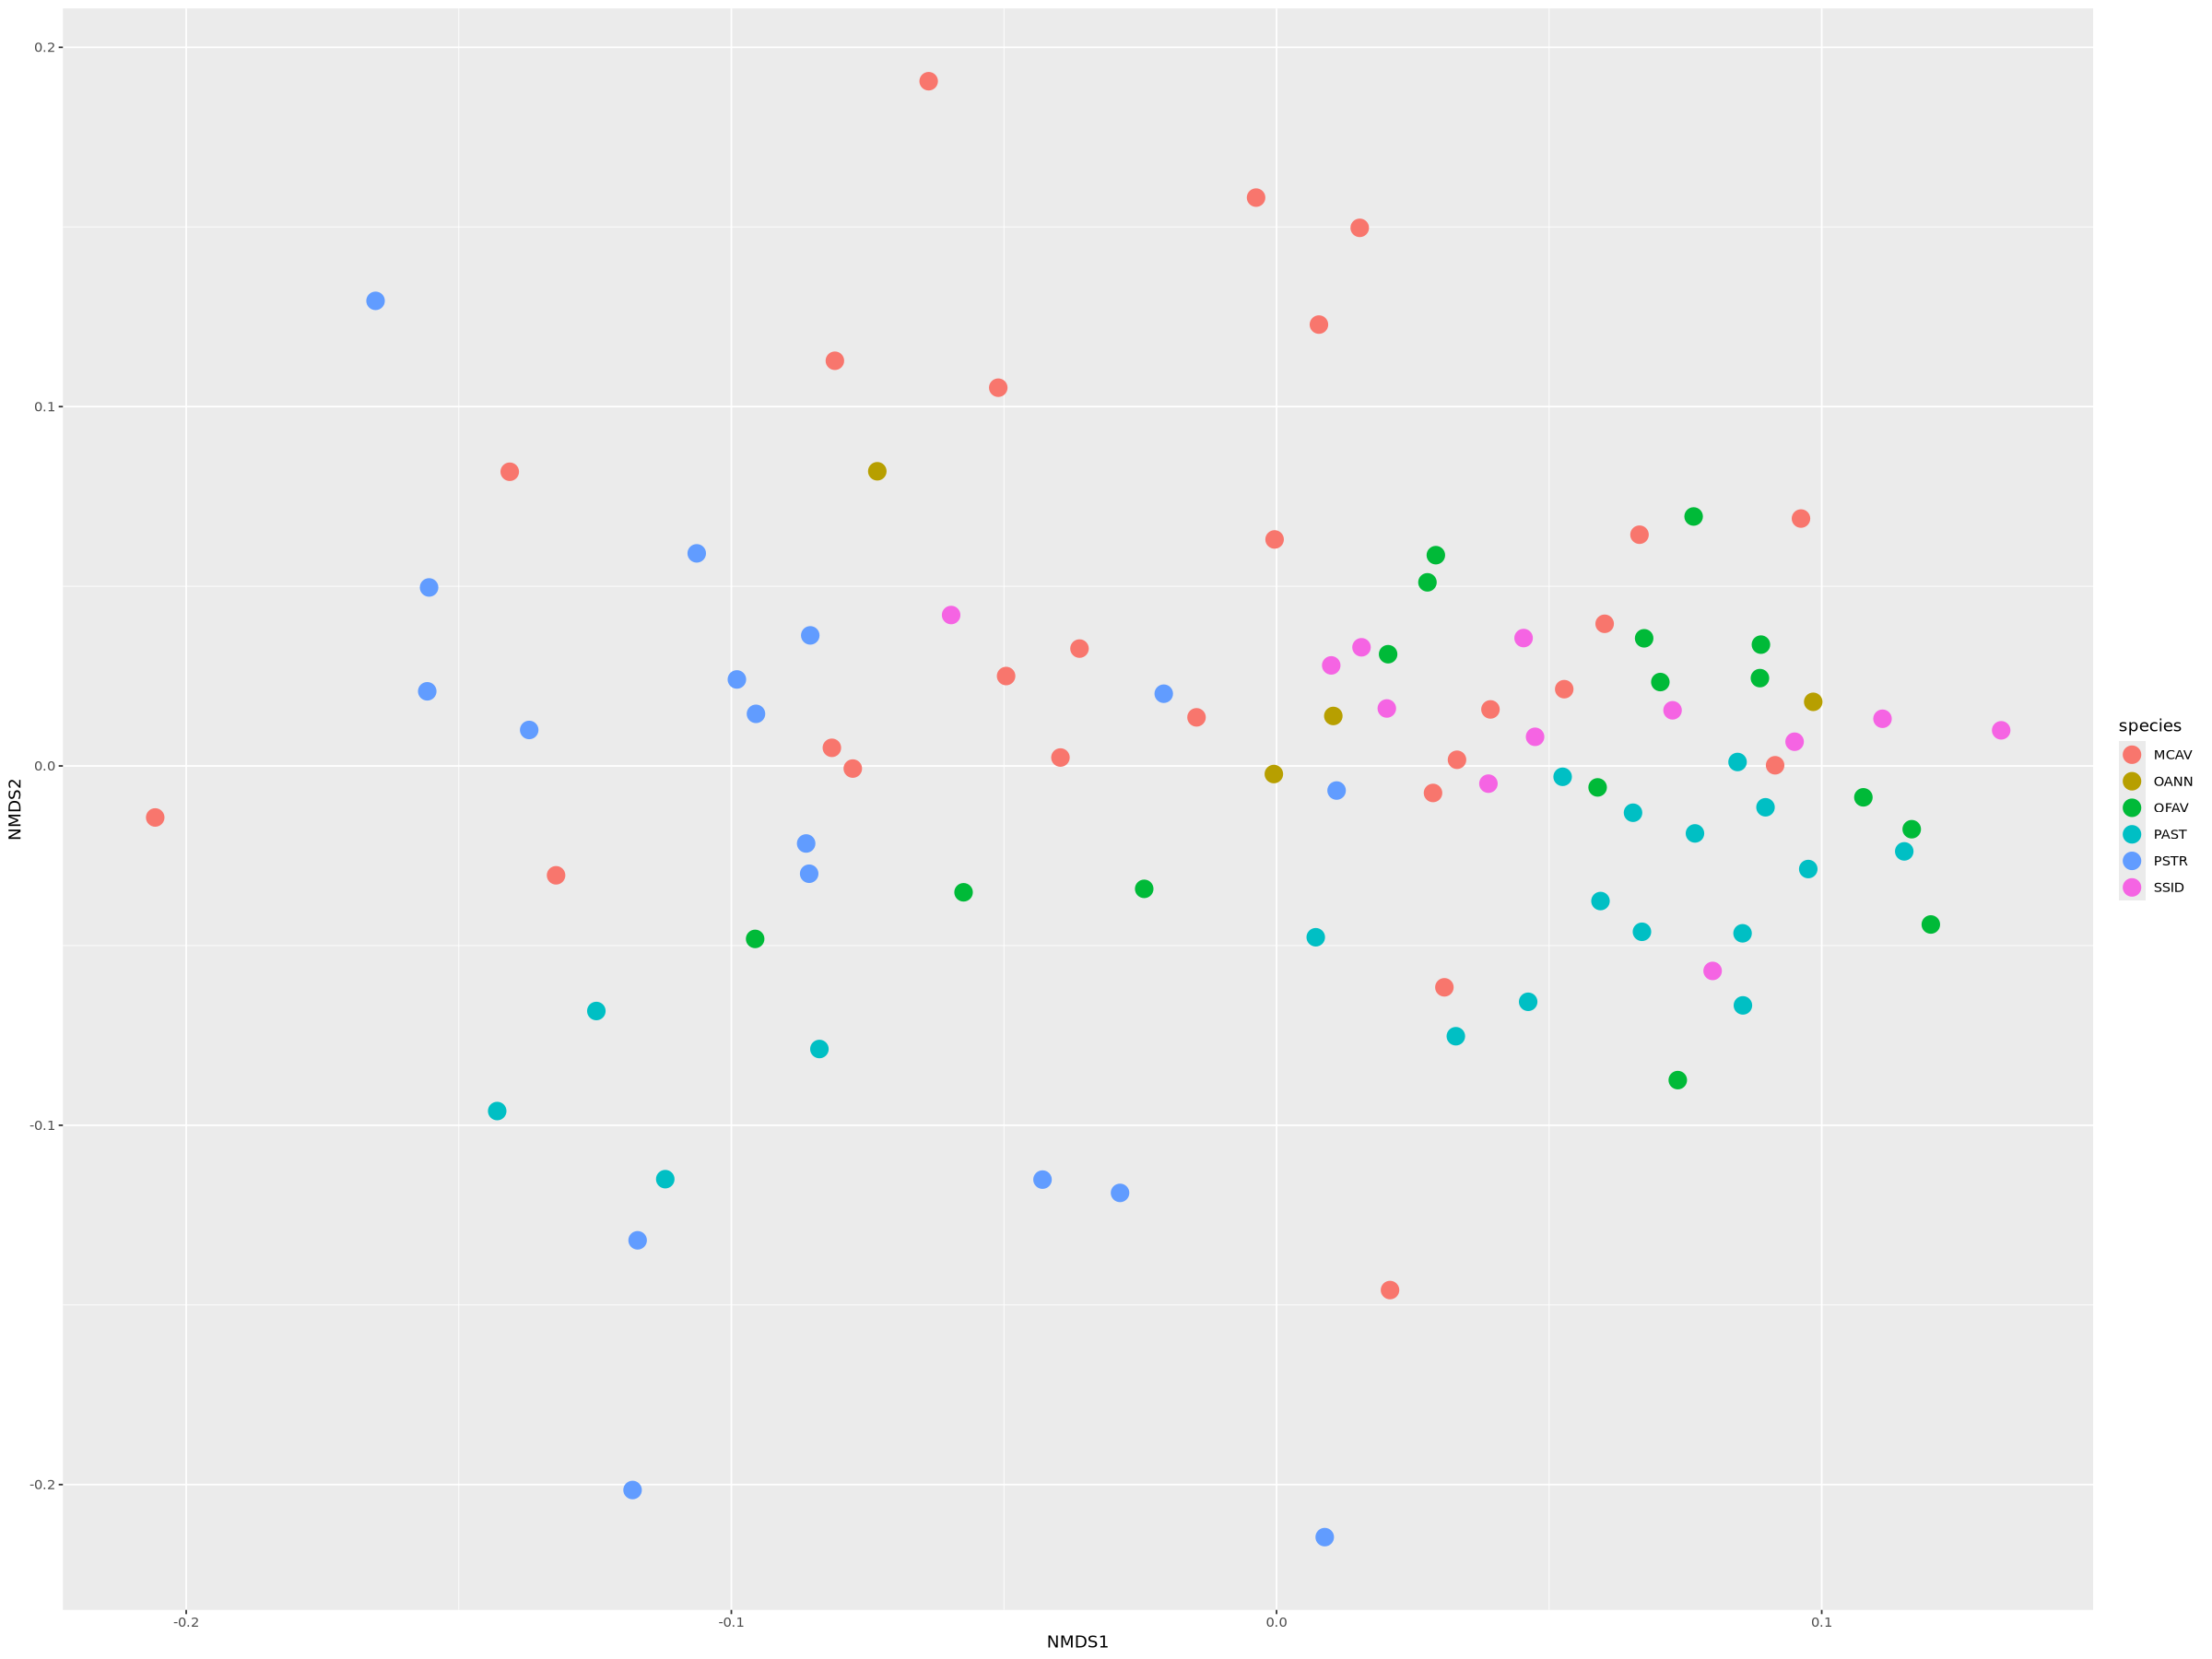

In [38]:
ps_norm.ord <- ordinate(ps_norm, "NMDS", "bray", trymax=1000)
plot_ordination(ps_norm, ps_norm.ord, type="samples", color="species")+ 
geom_point(size=5)

## nmds ordination using vegan

In [39]:
# convert the sample_data() within a phyloseq object to a vegan compatible data object
pssd2veg <- function(ps_norm) {
  sd <- sample_data(ps_norm)
  return(as(sd,"data.frame"))
}
# convert the otu_table() within a phyloseq object to a vegan compatible data object
psotu2veg <- function(ps_norm) {
  OTU <- otu_table(ps_norm)
  if (taxa_are_rows(OTU)) {
    OTU <- t(OTU)
  }
  return(as(OTU, "matrix"))
}

In [40]:
# Extract normalized OTU matrix and sample data
otu_norm <- psotu2veg(ps_norm)
sample_norm <- pssd2veg(ps_norm)

In [30]:
head(otu_norm)
head(sample_norm)

,ASV1,ASV2,ASV3,ASV4,ASV5,ASV6,ASV7,ASV8,ASV9,ASV10,⋯,ASV73947,ASV73948,ASV73949,ASV73950,ASV73951,ASV73952,ASV73953,ASV73954,ASV73955,ASV73956
012024_BEL_CBC_T1_557_SSID,411.55086,4930.036,40777.8311,0.0000,514.4386,102.88772,274.367241,3566.774,3198.0931,0.0000,⋯,0,0,0,0,0,0,0,0,0,0
012024_BEL_CBC_T1_563_PSTR,0.00000,3500.747,816.8409,186.7065,0.0000,186.70650,0.000000,31366.692,1096.9007,770.1643,⋯,0,0,0,0,0,0,0,0,0,0
012024_BEL_CBC_T2_601_OFAV,34.81005,1595.461,13419.2755,0.0000,684.5977,62176.55659,30261.539533,37606.461,3127.1031,0.0000,⋯,0,0,0,0,0,0,0,0,0,0
012024_BEL_CBC_T3_631_MCAV,113.53086,822.468,290.1344,0.0000,0.0000,20.18326,7.568724,441042.163,307.7948,0.0000,⋯,0,0,0,0,0,0,0,0,0,0
012024_BEL_CBC_T3_633_MCAV,343.03636,1127.119,0.0000,0.0000,0.0000,98.01039,261.361038,26462.805,1094.4493,0.0000,⋯,0,0,0,0,0,0,0,0,0,0
012024_BEL_CBC_T3_637_SSID,7033.46568,3176.404,3403.2898,4083.9478,0.0000,1928.53091,1418.037436,4821.327,4424.2768,0.0000,⋯,0,0,0,0,0,0,0,0,0,0


,Health_Status,colony,Date_16S,double_band,date_sampled,transect,species,MonthYear,TACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGG,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,⋯,CCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGTGTCAGCCGCCGCGGTGAAACTTAAGGGTTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGTAAAACATTTAAAATAAATAGAATTTTTTTAGTAATGGTGCAATATTAAAAGAAAAAAAAGAATTTTTTATGTGAAGACAATTTATTTTTTTTCTTTAACACGAAGGTTCTGGGAGCGAACAGGATTAGATACCCGTGTAGTCCTCTGTCTCTTATACACATCTCCGAGCCCACGAGACCCAAGA,CCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGTGTCAGCAGCCGCGGTGAAACTTAAGGGTTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGTAAAACATTTAAAATAAATAGAATTTTTTTAGTAATGGTGCAATATTAAAAGAAAAAAAAGAATTTTTTATGTGAAGACAATTTATTTTTTTTCTTTAACACGAAGGTTCTGGGAGCGAACAGGATTAGAAACCCCTGTAGTCCTCTGTCTCTTATACACATCTCCGAGCCCACGAGACCCAAGA,CCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGTGCCAGCAGCCGCGGTGAAACTTAAGGGTTTGTTTTTTAGAAAAAGCAGAAAGCGTGTAAAGGTAAAACATTTAAAATAAATAGAATTTTTTTAGTAATGGTGCAATATTAAAAGAAAAAAAAGAATTTTTTATGTGAAGACAATTTATTTTTTTTCTTTAACACGAAGGTTCTGGGAGCGAACAGGATTAGATACCCTCGTAGTCCGCTGTCTCTTATACACATCTCCGAGCCCACGAGACCCAAGA,TATTGGGCGTAAAGAGCACGTAGGCGGCGCGGTAAGTCCATTGTGAAAGCCCTCGGCTCAACCGAGGAAGTGCAGTGGAAACTGCCGTGCTTGAGTACGGGAGAGGAGAGTGGAATTCCCGGTGAAGCGGTGAAATGCGTAGATATCGGGAAGAACACCAGTGGCGAAAGCGGCTCTCTGGACCGTCACTGACGCTGAGGTGCGAAAGCTGGGGGAGCGAACGGGATTAGATACCCGGGTAGTCCCTGTCTCTTATACACATCTC,input,filtered,denoisedF,denoisedR,merged,nonchim
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
012024_BEL_CBC_T1_557_SSID,Healthy,1_3,3_4_2025,y,012024,T1,SSID,Jan 2024,48,575,⋯,0,0,0,0,140764,129588,127538,127742,124455,116632
012024_BEL_CBC_T1_563_PSTR,Healthy,1_12,3_6_2025,,012024,T1,PSTR,Jan 2024,0,150,⋯,0,0,0,0,95658,84750,84396,84350,83659,42848
012024_BEL_CBC_T2_601_OFAV,Healthy,2_79,3_4_2025,,012024,T2,OFAV,Jan 2024,6,275,⋯,0,0,0,0,263071,248657,247323,247818,245870,172364
012024_BEL_CBC_T3_631_MCAV,Healthy,3_21,3_4_2025,,012024,T3,MCAV,Jan 2024,45,326,⋯,0,0,0,0,512917,478523,477554,477401,471667,396368
012024_BEL_CBC_T3_633_MCAV,Healthy,3_2,3_6_2025,,012024,T3,MCAV,Jan 2024,21,69,⋯,0,0,0,0,159182,151169,150478,150356,148945,61218
012024_BEL_CBC_T3_637_SSID,Healthy,3_5,3_6_2025,,012024,T3,SSID,Jan 2024,124,56,⋯,0,0,0,0,21606,20037,19402,19429,18770,17630


In [41]:
NMDS2 <- metaMDS(otu_norm, k = 2, trymax = 100, trace = F)
NMDS2


Call:
metaMDS(comm = otu_norm, k = 2, trymax = 100, trace = F) 

global Multidimensional Scaling using monoMDS

Data:     wisconsin(sqrt(otu_norm)) 
Distance: bray 

Dimensions: 2 
Stress:     0.2232675 
Stress type 1, weak ties
Best solution was repeated 1 time in 22 tries
The best solution was from try 7 (random start)
Scaling: centring, PC rotation, halfchange scaling 
Species: expanded scores based on ‘wisconsin(sqrt(otu_norm))’ 


In [42]:
# Check matching sample order
all(rownames(NMDS2$points) == rownames(sample_norm))  # Should be TRUE

[1] TRUE

In [ ]:
#vector fitting using a regression
# The function envfit will add the environmental variables as vectors to the ordination plot
ef <- envfit(NMDS2, sample_norm, permu = 999)
ef

# The two last columns are of interest: the squared correlation coefficient and the associated p-value
# Plot the vectors of the significant correlations and interpret the plot
plot(NMDS2, type = "t", display = "sites")
plot(ef, p.max = 0.05)